# Getting started with Owl-ViT
- Ref: 
    - https://github.com/huggingface/notebooks/blob/main/examples/zeroshot_object_detection_with_owlvit.ipynb

    - https://huggingface.co/docs/transformers/en/model_doc/owlvit

    -![Image](https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/model_doc/owlvit_architecture.jpg)

    <!-- - ![Image](https://camo.githubusercontent.com/22218c5bad1a8f719602978cf895f3e26c0f06af7776e5bd817d7d2f681f3e08/68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f676f6f676c652d72657365617263682f7363656e69632f613431643234363736663634613231353862666364376362373962306138373637336161383735622f7363656e69632f70726f6a656374732f6f776c5f7669742f646174612f6f776c5f7669745f736368656d617469632e706e67) -->



----

### Conda env : [cv_playgrounds](../../../README.md#setup-a-conda-environment)


## Configure device

In [64]:
#@title
import torch

if torch.backends.mps.is_available():
    t_device = torch.device("mps")
    s_device = "mps"
    print(f"Current memory allocated on MPS: {torch.mps.current_allocated_memory()} bytes")
    print(f"Driver memory allocated on MPS: {torch.mps.driver_allocated_memory()} bytes")
    if torch.mps.driver_allocated_memory() - torch.mps.current_allocated_memory()< 1e4:
        print("Not enough mps memory, convert to cpu mode")
        t_device = torch.device("cpu")
        s_device = "cpu"
elif torch.cuda.is_available():
    t_device = torch.device("cuda")
    s_device = "cuda"
else:
    t_device = torch.device("cpu")
    s_device = "cpu"
print(t_device)

cuda


### Load pre-trained model and processor

In [65]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

### Preprocess input image and text queries

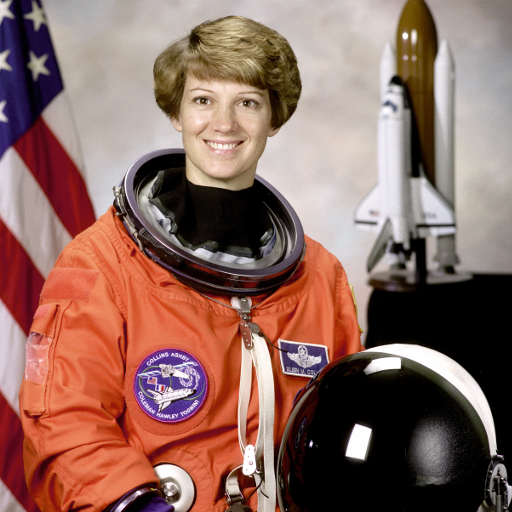

In [66]:
import cv2
import skimage
import numpy as np
from PIL import Image

# Download sample image
image = skimage.data.astronaut()
image = Image.fromarray(np.uint8(image)).convert("RGB")

# Text queries to search the image for
text_queries = ["human face", "rocket", "nasa badge", "star-spangled banner"]

image

In [67]:
# Process image and text inputs
inputs = processor(text=text_queries, images=image, return_tensors="pt").to(t_device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([4, 16])
attention_mask: torch.Size([4, 16])
pixel_values: torch.Size([1, 3, 768, 768])


- input_ids — List of token ids to be fed to a model. Returned when text is not None.
- attention_mask — List of indices specifying which tokens should be attended to by the model (when return_attention_mask=True or if “attention_mask” is in self.model_input_names and if text is not None).
- pixel_values — Pixel values to be fed to a model. Returned when images is not None.
- query_pixel_values — Pixel values of the query images to be fed to a model. Returned when query_images is not None.

In [68]:
print(type(inputs))
inputs['input_ids']

<class 'transformers.image_processing_base.BatchFeature'>


tensor([[49406,  2751,  1710, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  8383, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  6841, 11301, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0],
        [49406,  1565,   268,   588, 32322,  9185, 49407,     0,     0,     0,
             0,     0,     0,     0,     0,     0]], device='cuda:0')

### Forward pass

In [ ]:
# Set model in evaluation mode
model = model.to(t_device)
model.eval()

# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 4])
pred_boxes: shape of torch.Size([1, 576, 4])
text_embeds: shape of torch.Size([1, 4, 512])
image_embeds: shape of torch.Size([1, 24, 24, 768])
class_embeds: shape of torch.Size([1, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([4, 16, 512])
pooler_output: shape of torch.Size([4, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [70]:
outputs

OwlViTObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[ -6.5953,  -7.3036,  -7.0607,  -5.7305],
         [ -6.4362,  -7.0800,  -6.7687,  -5.5453],
         [ -9.3801,  -9.4900,  -8.8833,  -7.6674],
         ...,
         [ -7.4914,  -8.5911,  -8.4306,  -9.4235],
         [ -6.4554,  -9.0884,  -7.6951,  -9.0162],
         [-15.0583, -15.1023, -15.1131, -15.8608]]], device='cuda:0'), pred_boxes=tensor([[[0.0143, 0.0236, 0.0285, 0.0452],
         [0.0649, 0.0247, 0.0437, 0.0482],
         [0.0601, 0.0446, 0.0699, 0.0873],
         ...,
         [0.8484, 0.9998, 0.3168, 0.1841],
         [0.9598, 0.9998, 0.0581, 0.0988],
         [0.9999, 0.9998, 0.2105, 0.1626]]], device='cuda:0'), text_embeds=tensor([[[ 0.0104,  0.0166, -0.0250,  ...,  0.0432,  0.0120, -0.0517],
         [ 0.0123, -0.0183, -0.0156,  ...,  0.0264,  0.0792, -0.0615],
         [ 0.0429, -0.0494, -0.0001,  ...,  0.0777,  0.0110, -0.0422],
         [ 0.0610, -0.0552,  0.0238,  ..., -0.0008, -0.0196, -0.0004]]

### Draw predictions on image

In [71]:
import matplotlib.pyplot as plt

from transformers.image_utils import ImageFeatureExtractionMixin
mixin = ImageFeatureExtractionMixin()

# Load example image
image_size = model.config.vision_config.image_size
image = mixin.resize(image, image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][0], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][0].cpu().detach().numpy()

In [73]:
print(outputs["logits"].shape)
logits = torch.max(outputs["logits"][0], dim=-1)
print(labels.shape)
print(boxes.shape)
print(scores.shape)

torch.Size([1, 576, 4])
(576,)
(576, 4)
(576,)


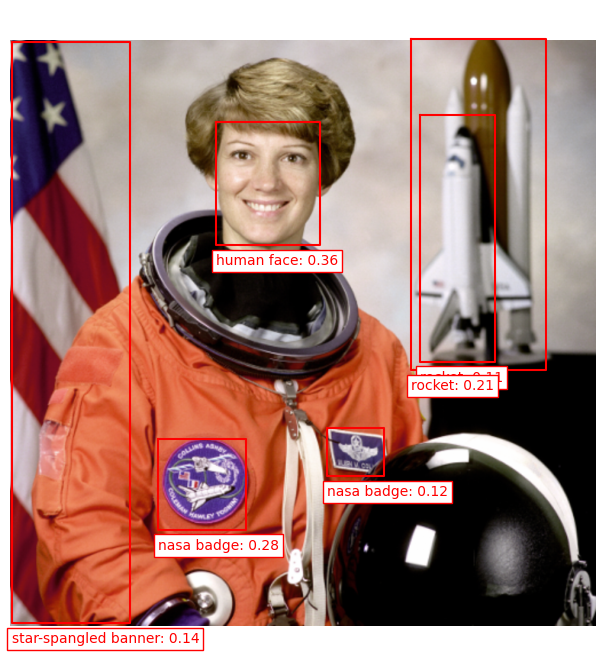

In [ ]:
def plot_predictions(input_image, text_queries, scores, boxes, labels):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(input_image, extent=(0, 1, 1, 0))
    ax.set_axis_off()

    for score, box, label in zip(scores, boxes, labels):

      if score < score_threshold:
        continue

      # print(score)
      # print(box)
      # print(label)
      # print()

      cx, cy, w, h = box
      ax.plot([cx-w/2, cx+w/2, cx+w/2, cx-w/2, cx-w/2],
              [cy-h/2, cy-h/2, cy+h/2, cy+h/2, cy-h/2], "r")
      ax.text(
          cx - w / 2,
          cy + h / 2 + 0.015,
          f"{text_queries[label]}: {score:1.2f}",
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })

plot_predictions(input_image, text_queries, scores, boxes, labels)

### Batch processing

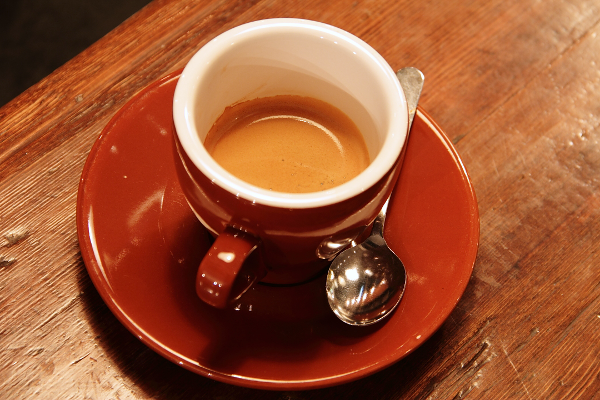

In [50]:
# Download the coffee mug image
image = skimage.data.coffee()
image = Image.fromarray(np.uint8(image)).convert("RGB")
image

In [51]:
# Preprocessing
images = [skimage.data.astronaut(), skimage.data.coffee()]
images = [Image.fromarray(np.uint8(img)).convert("RGB") for img in images]

# Nexted list of text queries to search each image for
text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate"]]
# text_queries = [["human face", "rocket", "nasa badge", "star-spangled banner"], ["coffee mug", "spoon", "plate", "nasa badge", "1", "2", "3"]]

# Process image and text inputs
inputs = processor(text=text_queries, images=images, return_tensors="pt").to(t_device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

input_ids: torch.Size([8, 16])
attention_mask: torch.Size([8, 16])
pixel_values: torch.Size([2, 3, 768, 768])


In [ ]:
# inputs["attention_mask"]

In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nText model outputs")
for k, val in outputs.text_model_output.items():
    print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([2, 576, 4])
pred_boxes: shape of torch.Size([2, 576, 4])
text_embeds: shape of torch.Size([2, 4, 512])
image_embeds: shape of torch.Size([2, 24, 24, 768])
class_embeds: shape of torch.Size([2, 576, 512])

Text model outputs
last_hidden_state: shape of torch.Size([8, 16, 512])
pooler_output: shape of torch.Size([8, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([2, 577, 768])
pooler_output: shape of torch.Size([2, 768])


In [53]:
outputs.logits

tensor([[[ -6.5953,  -7.3036,  -7.0607,  -5.7305],
         [ -6.4362,  -7.0800,  -6.7687,  -5.5453],
         [ -9.3801,  -9.4900,  -8.8833,  -7.6674],
         ...,
         [ -7.4914,  -8.5911,  -8.4306,  -9.4235],
         [ -6.4554,  -9.0884,  -7.6951,  -9.0162],
         [-15.0583, -15.1023, -15.1131, -15.8608]],

        [[ -8.6455,  -9.1923,  -8.7057, -12.0101],
         [ -8.4417,  -8.6664,  -7.9273, -11.9941],
         [ -9.5233,  -9.6289,  -8.9595, -12.6013],
         ...,
         [-13.1097, -12.6488, -12.6215, -11.9817],
         [-12.6505, -12.2655, -12.5732, -11.8831],
         [-16.6883, -16.8570, -16.4795, -15.9039]]], device='cuda:0')

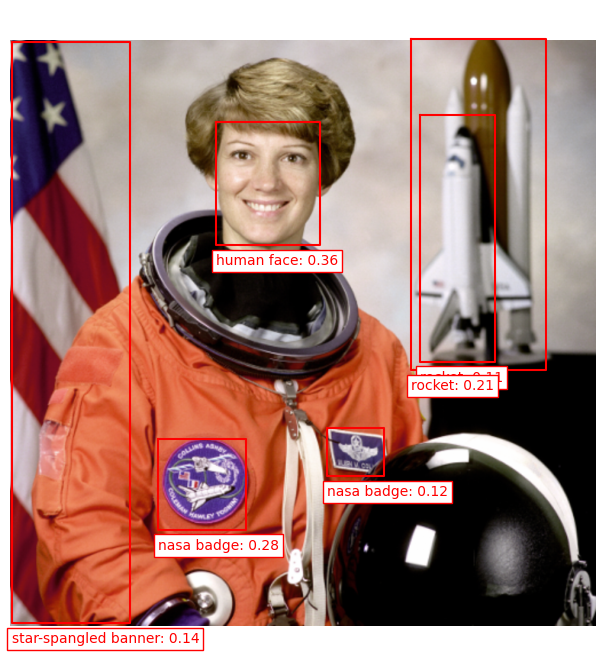

In [54]:
# Let's plot the predictions for the second image
image_idx = 0
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs.logits[image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

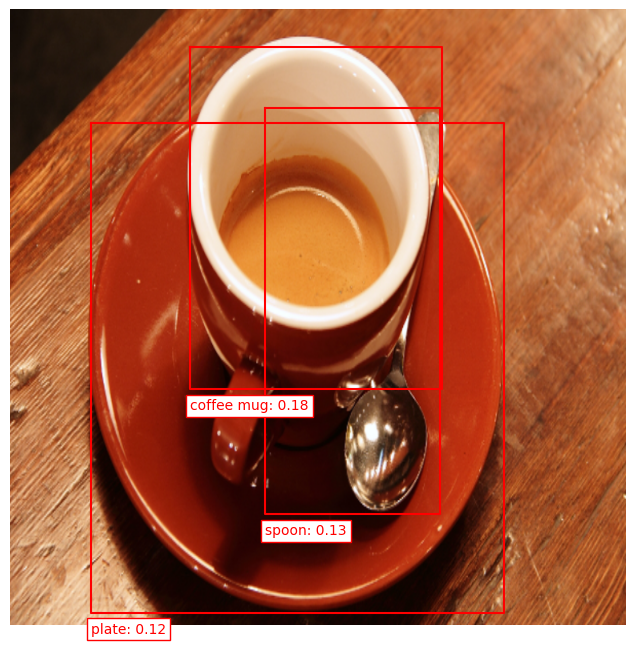

In [55]:
# Let's plot the predictions for the second image
image_idx = 1
image_size = model.config.vision_config.image_size
image = mixin.resize(images[image_idx], image_size)
input_image = np.asarray(image).astype(np.float32) / 255.0

# Threshold to eliminate low probability predictions
score_threshold = 0.1

# Get prediction logits
logits = torch.max(outputs["logits"][image_idx], dim=-1)
scores = torch.sigmoid(logits.values).cpu().detach().numpy()

# Get prediction labels and boundary boxes
labels = logits.indices.cpu().detach().numpy()
boxes = outputs["pred_boxes"][image_idx].cpu().detach().numpy()

plot_predictions(input_image, text_queries[image_idx], scores, boxes, labels)

### Post-processing model predictions

In [56]:
# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([img.size[::-1] for img in images]).to(t_device)

# Convert outputs (bounding boxes and class logits) to COCO API
results = processor.post_process(outputs=outputs, target_sizes=target_sizes)

# Loop over predictions for each image in the batch
for i in range(len(images)):
    print(f"\nProcessing image {i}")
    text = text_queries[i]
    boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

    score_threshold = 0.1
    for box, score, label in zip(boxes, scores, labels):
        box = [round(i, 2) for i in box.tolist()]

        if score >= score_threshold:
            print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")

/home/hyunjae/anaconda3/envs/dl_drill_pthf/lib/python3.10/site-packages/transformers/models/owlvit/image_processing_owlvit.py:465: FutureWarning: `post_process` is deprecated and will be removed in v5 of Transformers, please use `post_process_object_detection` instead, with `threshold=0.` for equivalent results.
  warnings.warn(



Processing image 0
Detected human face with confidence 0.357 at location [180.23, 71.53, 271.25, 178.76]
Detected rocket with confidence 0.106 at location [358.81, 64.85, 424.18, 280.84]
Detected star-spangled banner with confidence 0.138 at location [1.43, 1.26, 105.38, 509.68]
Detected rocket with confidence 0.211 at location [350.98, -1.17, 468.6, 288.51]
Detected nasa badge with confidence 0.281 at location [129.58, 348.54, 206.46, 427.98]
Detected nasa badge with confidence 0.12 at location [277.15, 338.86, 327.42, 380.85]

Processing image 1
Detected coffee mug with confidence 0.175 at location [175.23, 24.72, 420.98, 246.83]
Detected spoon with confidence 0.132 at location [248.54, 63.72, 418.45, 327.98]
Detected plate with confidence 0.115 at location [78.9, 74.04, 481.06, 391.81]


## Bonus: one-shot / image-guided object detection

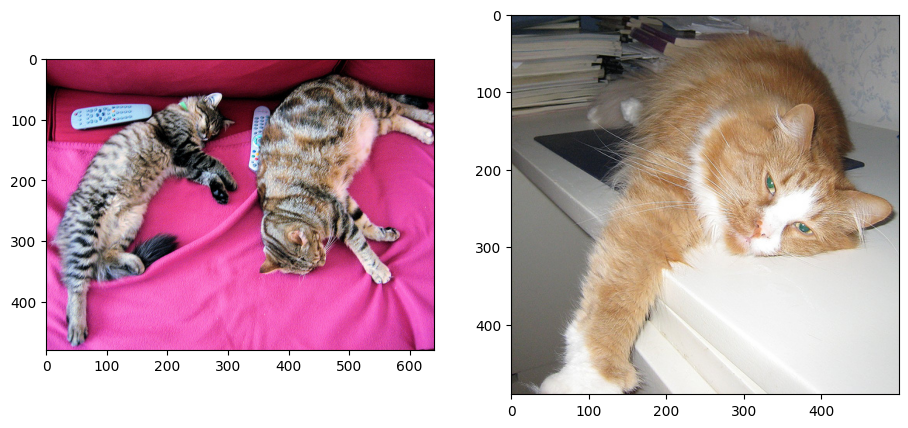

In [57]:
import cv2
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "http://images.cocodataset.org/val2017/000000058111.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [58]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(t_device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [ ]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}")

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


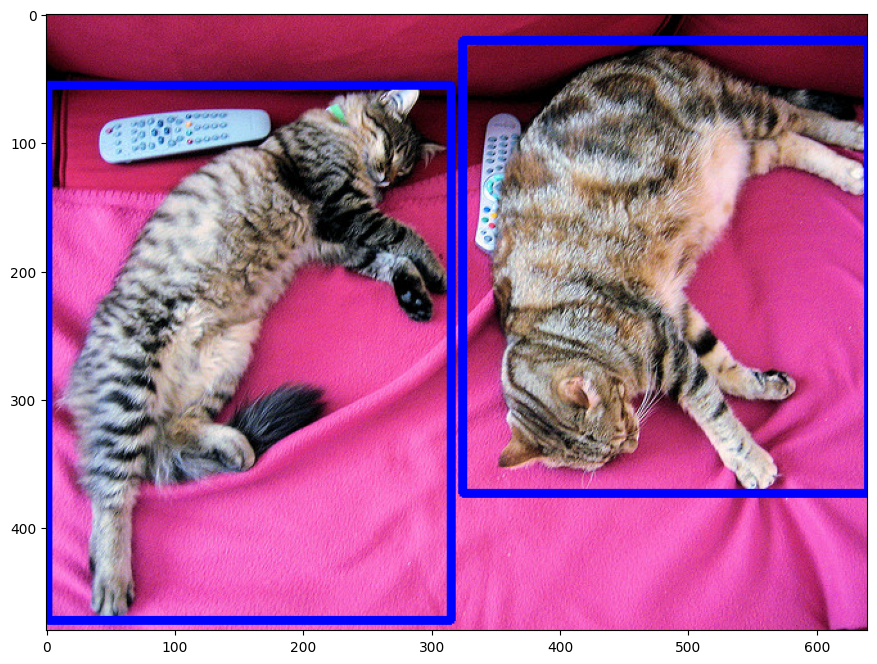

In [ ]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu()

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    # if box[3] + 25 > 768:
    #     y = box[3] - 10
    # else:
    #     y = box[3] + 25

plt.imshow(img[:,:,::-1])

In [ ]:
results



[{'scores': tensor([0.9927, 1.0000]),
  'labels': None,
  'boxes': tensor([[324.9655,  20.4363, 640.5834, 373.2883],
          [  1.4641,  55.2603, 315.5512, 472.1703]])}]

In [ ]:
print("Done")